In [1]:
import os, sys, time
import uproot3 as uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numbers import Integral
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from scipy.stats import norm, truncnorm, foldnorm
import warnings
from time import perf_counter
from scipy.spatial.distance import cdist

from farich_functions import *

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
datadir = 'data'

In [4]:
filepath = os.path.join(datadir, 'fullsim_optical_1000_pi_1500_no.root')
filepath_fixed = os.path.join(datadir, 'fullsim_optical_1000_pi_1500_fixed.root')
filepath_2pi = os.path.join(datadir, 'fullsim_optical_1000_pi_1500_2pi_phi.root')
filepath_prototype = os.path.join(datadir, 'farichsim_10kevt.root')
filepath_new = os.path.join(datadir, 'fullsim_optical_1000_pi_1500_spectre_test_3.root')

In [5]:
# file = uproot.open(filepath)
file = uproot.open(filepath_fixed)
# file_2pi = uproot.open(filepath_2pi)
file_prototype = uproot.open(filepath_prototype)
# file_new = uproot.open(filepath_new)

In [6]:
plt.style.use('default')

In [ ]:
plot_cyl(file, transposed=True)

In [52]:
np.concatenate(np.array(file['events;1']['FarichBarrelG4Hits.postStepPosition.x'].array())).shape

(470755,)

# Main (tmp obv)

In [8]:
norm_r = 1007.0091186826339

In [9]:
pdes_tmp = pd.read_csv('PDE.csv', sep=';', names=['A'])
t1 = []
t2 = []
for inedx, row in pdes_tmp.iterrows():
    t1.append(float(row['A'].split(';')[0].replace(',', '.')))
    t2.append(float(row['A'].split(';')[1].replace(',', '.')))
PDE_wvs = np.linspace(200, 900, 128)
PDEs = np.interp(PDE_wvs, t1, t2, left=0, right=0)
# sipm_eff = {key: value for key, value in zip(PDE_wvs, PDEs)}
sipm_eff = fix_PDE_plot(PDEs, PDE_wvs)

In [10]:
x_grid = np.arange(-3*norm_r * np.sin(np.pi / 27), 3*norm_r * np.sin(np.pi / 27), SIPM_CELL_SIZE)
# x_grid = np.arange(-norm_r * np.sin(np.pi / 27), norm_r * np.sin(np.pi / 27), 3.16)
z_grid = np.arange(-1400, 1400, SIPM_CELL_SIZE)
grid = (x_grid, z_grid, PDE_wvs)

In [11]:
x = np.array(file['events;2']['FarichBarrelG4Hits.postStepPosition.x'].array())
y = np.array(file['events;2']['FarichBarrelG4Hits.postStepPosition.y'].array())
z = np.array(file['events;2']['FarichBarrelG4Hits.postStepPosition.z'].array())
wvs = 1239.841 / np.array(file['events;2']['FarichBarrelG4Hits.energy'].array()) * 1e-9

In [12]:
for i in range(len(wvs)):
    wvs[i] = lin_move_to_grid(wvs[i], grid[2])

In [13]:
coordinates = np.column_stack((x, y, z, wvs))

coordinates.shape

(1000, 4)

In [14]:
idx_to_drop = []
for i in range(coordinates.shape[0]):
    if coordinates[i][0].shape[0] == 0:
        idx_to_drop.append(i)

In [15]:
coordinates = np.delete(coordinates, idx_to_drop, axis=0)

In [16]:
coordinates.shape

(998, 4)

In [17]:
sipm_sim(coordinates, sipm_eff)

In [18]:
plot_cyl(file, coordinates, True)

In [19]:
idx_to_drop = []
for i in range(coordinates.shape[0]):
    if coordinates[i][0].shape[0] == 0:
        idx_to_drop.append(i)
coordinates = np.delete(coordinates, idx_to_drop, axis=0)
coordinates.shape

(984, 4)

In [20]:
rotate_events(coordinates)

In [21]:
plot_cyl(file, coordinates)

In [22]:
move_events_to_grid(coordinates, grid)

In [23]:
plot_cyl(file, coordinates, True)

In [34]:
coordinates

array([[array([ 32.32013058,  12.16013058, 112.96013058,  12.16013058,
               133.12013058, 129.76013058,  89.44013058,  22.24013058,
               123.04013058, 106.24013058, 129.76013058,  12.16013058,
                59.20013058,  86.08013058, 126.40013058,  69.28013058,
                92.80013058,   8.80013058, 126.40013058, 129.76013058,
                72.64013058, 116.32013058, 126.40013058,  59.20013058,
               123.04013058, 119.68013058,  39.04013058, 116.32013058,
               102.88013058,   8.80013058,  18.88013058,  22.24013058,
               123.04013058, 133.12013058,  49.12013058,  45.76013058,
               112.96013058, 116.32013058, 109.60013058,   8.80013058,
               126.40013058, 123.04013058,  52.48013058,   8.80013058,
               133.12013058,  12.16013058,  49.12013058,  76.00013058,
               109.60013058, 116.32013058,  25.60013058, 126.40013058,
                22.24013058,  52.48013058, 119.68013058, 106.24013058,
      

In [36]:
edf = pd.DataFrame(coordinates, columns=['x_c', 'y_c', 'z_c', 'wv_c'])
edf

,x_c,y_c,z_c,wv_c
0,"[32.32013058436115, 12.16013058436107, 112.960...","[1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000....","[155.67999999995368, 125.43999999995458, 152.3...","[414.96062992125985, 409.4488188976378, 718.11..."
1,"[-95.35986941563937, -209.59986941563983, -122...","[1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000....","[-472.6400000000276, -546.5600000000254, -586....","[403.93700787401576, 442.5196850393701, 337.79..."
2,"[102.88013058436144, 123.04013058436152, 119.6...","[1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000....","[985.599999999929, 931.8399999999306, 1133.439...","[359.8425196850394, 519.6850393700788, 563.779..."
3,"[89.44013058436138, 86.08013058436137, 92.8001...","[1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000....","[118.71999999995478, 111.99999999995498, 118.7...","[558.267716535433, 712.5984251968504, 370.8661..."
4,"[2.0801305843610294, -14.719869415639039, 32.3...","[1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000....","[-375.2000000000305, -297.9200000000328, -257....","[508.66141732283467, 734.6456692913385, 607.87..."
...,...,...,...,...
979,"[42.40013058436119, 82.72013058436136, 123.040...","[1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000....","[-277.7600000000334, -156.80000000003702, -190...","[613.3858267716536, 326.7716535433071, 701.574..."
980,"[-91.99986941563935, -172.63986941563968, -98....","[1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000....","[246.39999999995098, 152.31999999995378, 169.1...","[420.4724409448819, 536.2204724409448, 376.377..."
981,"[-65.11986941563924, -58.399869415639216, -102...","[1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000....","[397.5999999999465, 400.9599999999464, 380.799...","[370.8661417322835, 381.8897637795276, 442.519..."
982,"[35.680130584361166, 49.12013058436122, 136.48...","[1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000....","[-89.60000000003902, -156.80000000003702, -163...","[359.8425196850394, 425.98425196850394, 403.93..."


In [47]:
unraveled_data = {col: [] for col in edf.columns}
row_indices = []

# Iterate over the DataFrame and unravel the arrays
for i, row in edf.iterrows():
    max_length = max(len(row[col]) for col in edf.columns)
    for k in range(max_length):
        row_indices.append((i, k))
        for col in edf.columns:
            if k < len(row[col]):
                unraveled_data[col].append(row[col][k])
            else:
                unraveled_data[col].append(np.nan)  # Handle cases where arrays are of different lengths

# Create a new DataFrame from the unraveled data
unraveled_df = pd.DataFrame(unraveled_data)

# Create a MultiIndex for the rows
multi_index = pd.MultiIndex.from_tuples(row_indices, names=['entry', 'subentry'])
unraveled_df.index = multi_index


In [48]:
unraveled_df

x_c     y_c     z_c        wv_c
entry subentry                                        
0     0          32.320131  1000.0  155.68  414.960630
      1          12.160131  1000.0  125.44  409.448819
      2         112.960131  1000.0  152.32  718.110236
      3          12.160131  1000.0  132.16  387.401575
      4         133.120131  1000.0  101.92  503.149606
...                    ...     ...     ...         ...
983   103       237.280131  1000.0  693.28  657.480315
      104       237.280131  1000.0  726.88  464.566929
      105       237.280131  1000.0  713.44  613.385827
      106       213.760131  1000.0  800.80  475.590551
      107       220.480131  1000.0  663.04  492.125984

[86682 rows x 4 columns]

primary particle - last with wv = 0

In [24]:
# coordinates[:,3]
lambdas = np.concatenate(coordinates[:,3])

In [25]:
lambdas.shape

(86682,)

In [26]:
lambdas.shape[0] / coordinates.shape[0]

88.09146341463415

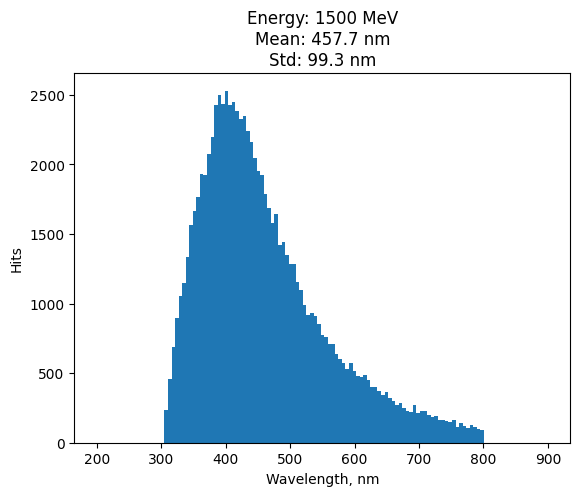

In [27]:
plt.hist(lambdas, bins=PDE_wvs)
plt.xlabel('Wavelength, nm')
plt.title(f'Energy: 1500 MeV\nMean: {round(lambdas.mean(), 1)} nm' + '\n' + f'Std: {round(lambdas.std(), 1)} nm')
plt.ylabel('Hits')
# plt.xlim((200, 900))
plt.show()

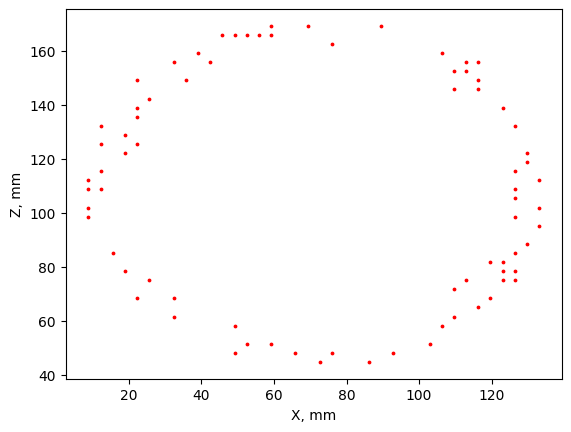

In [28]:
# delta_r = np.sqrt(x ** 2 + y ** 2 - 1000 ** 2)
plt.scatter(coordinates[0][0], coordinates[0][2], c='red', s=3)
# plt.plot(1000 * np.cos(np.linspace(0, 2*np.pi,1000)), 1000 * np.sin(np.linspace(0, 2*np.pi,1000)))
# plt.xlim((-160, 50))
# plt.ylim((-1100, -650))
plt.xlabel('X, mm')
plt.ylabel('Z, mm')
# plt.title('p = 1500 MeV' + f'\n{coordinates[0][0].shape[0]} Hits')
plt.show()

In [29]:
print(coordinates[0][0].shape)

(77,)


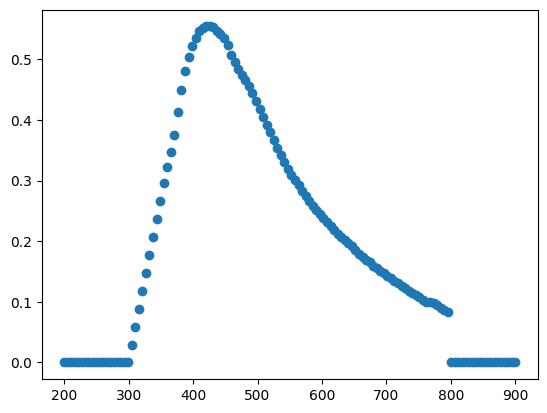

In [30]:
plt.scatter(PDE_wvs, PDEs)
plt.show()

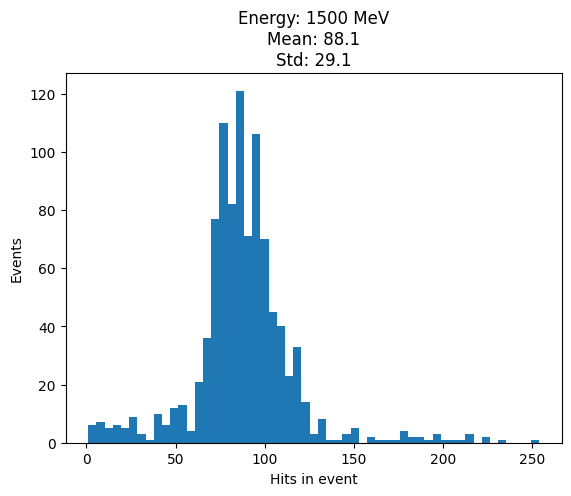

In [31]:
events_len = []
for i in range(coordinates.shape[0]):
    events_len.append(len(coordinates[i][0]))
events_len = np.array(events_len)
plt.hist(events_len, bins='auto')
plt.xlabel('Hits in event')
plt.title(f'Energy: 1500 MeV\nMean: {round(events_len.mean(), 1)}' + '\n' + f'Std: {round(events_len.std(), 1)}')
plt.ylabel('Events')
plt.show()

# End of main

In [89]:
coordinates[0]

array([array([ 34.80013058, 123.28013058,  34.80013058,  69.56013058,
              113.80013058,  12.68013058, 132.76013058, 126.44013058,
              132.76013058, 129.60013058, 132.76013058, 126.44013058,
               41.12013058, 132.76013058, 113.80013058, 110.64013058,
              132.76013058, 123.28013058,  56.92013058,  85.36013058,
               94.84013058,  82.20013058,  63.24013058,   9.52013058,
              126.44013058, 126.44013058,  12.68013058, 120.12013058,
              126.44013058, 120.12013058,  72.72013058, 116.96013058,
               60.08013058, 123.28013058,  63.24013058, 113.80013058,
              104.32013058,  82.20013058,  72.72013058,  22.16013058,
              123.28013058, 132.76013058,  41.12013058,  28.48013058,
               85.36013058, 132.76013058, 116.96013058,  50.60013058,
                9.52013058, 123.28013058, 129.60013058,  53.76013058,
               12.68013058,  15.84013058, 116.96013058,  66.40013058,
                6.36

In [46]:
lambdas = 1239.841 / np.array(file['events;2']['FarichBarrelG4Hits.energy'].array()) * 1e-9

In [47]:
lambdas = np.concatenate(lambdas)

In [48]:
lambdas = lambdas[lambdas > 150]

In [42]:
mask = (lambdas >= 380) & (lambdas <= 780)

In [43]:
lambdas[mask].shape[0] / lambdas.shape[0]

0.3333763414745215

In [52]:
lambdas.shape[0]

527032

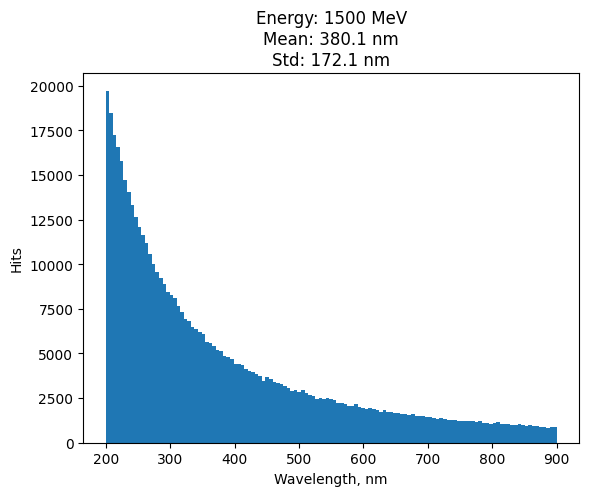

In [46]:
plt.hist(lambdas, bins='auto')
plt.xlabel('Wavelength, nm')
plt.title(f'Energy: 1500 MeV\nMean: {round(lambdas.mean(), 1)} nm' + '\n' + f'Std: {round(lambdas.std(), 1)} nm')
plt.ylabel('Hits')
plt.show()

In [47]:
cut_shapes = np.zeros(1000)
for num in range(1000):
    # arr = 1239.841 / np.array(file['events;2']['FarichBarrelG4Hits.energy'].array())[num] * 1e-9
    # mask = (arr >= 350) & (arr <= 800)
    # cut_shapes[num] = arr[mask].shape[0]
    cut_shapes[num] = np.array(file['events;2']['FarichBarrelG4Hits.energy'].array())[num].shape[0]

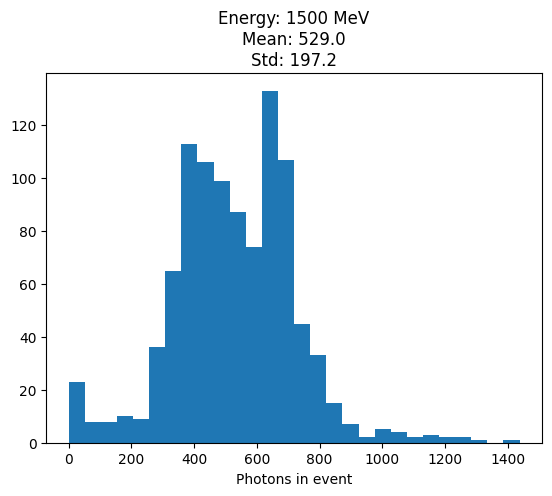

In [48]:
plt.hist(cut_shapes, bins='auto')
plt.title(f'Energy: 1500 MeV\nMean: {round(cut_shapes.mean(), 1)}' + '\n' + f'Std: {round(cut_shapes.std(), 1)}')
plt.xlabel('Photons in event')
plt.show()

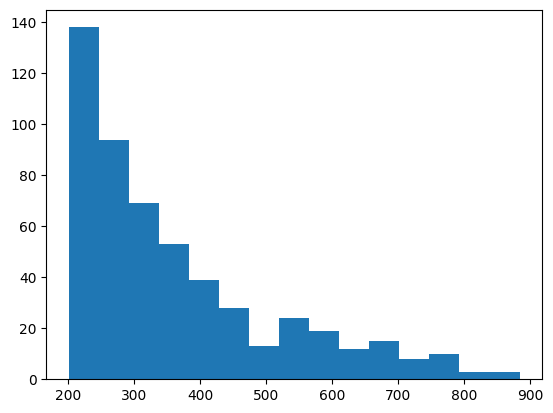

In [49]:
num = 5
plt.hist(1239.841 / (1 * (np.array(file['events;2']['FarichBarrelG4Hits.energy'].array())[num][np.array(file['events;2']['FarichBarrelG4Hits.energy'].array())[num] < 1e-8] * 1e9)), bins='auto')
plt.show()

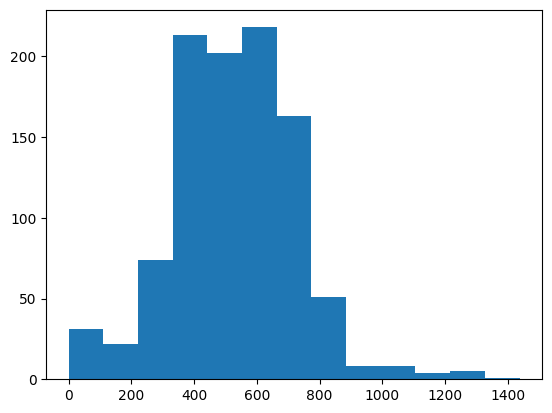

In [50]:
plt.hist([np.array(file['events;2']['FarichBarrelG4Hits.energy'].array())[i].shape[0] for i in range(1000)], bins='doane')
plt.show()

In [51]:
minn = 1
for i in range(1000):
    try:
        tmp  = min(np.array(file['events;2']['FarichBarrelG4Hits.energy'].array())[i])
    except ValueError:
        pass
    minn = min(minn, tmp)
print(minn)

1.3776198951913162e-09


In [53]:
pdes_tmp = pd.read_csv('PDE.csv', sep=';', names=['A'])
t1 = []
t2 = []
for inedx, row in pdes_tmp.iterrows():
    t1.append(float(row['A'].split(';')[0].replace(',', '.')))
    t2.append(float(row['A'].split(';')[1].replace(',', '.')))

In [54]:
t1 = np.array(t1)
t2 = np.array(t2)

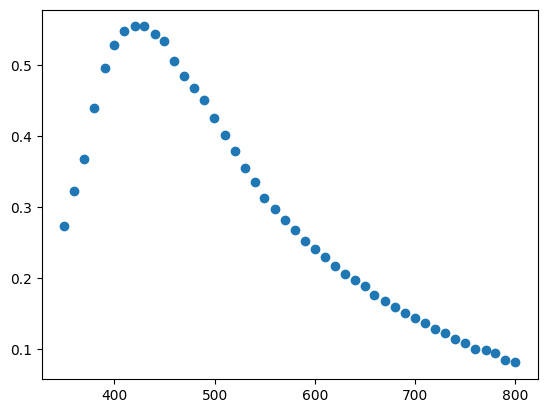

In [56]:
plt.scatter(t1, t2)
plt.show()

In [65]:
t1.shape

(46,)

In [51]:
a1, a2_ = np.histogram(lambdas, bins=128)

In [67]:
PDE_wvs = (PDE_wvs[1:] + PDE_wvs[:-1]) / 2

In [54]:
PDE_wvs.shape

(128,)

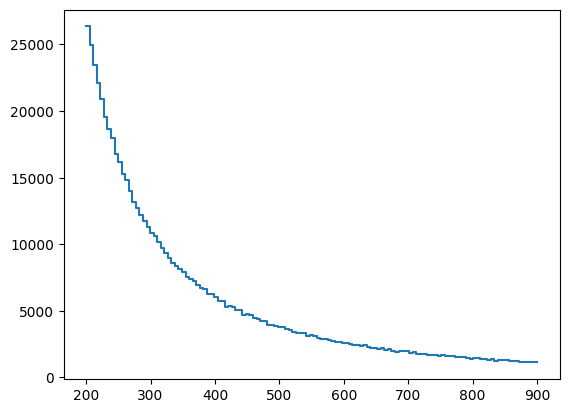

In [53]:
plt.step(PDE_wvs, a1, where='post')
plt.show()

In [70]:
a1.shape

(127,)

In [71]:
a1.sum()

527032

In [72]:
# conv_x = np.arange(min(t1.min(), a2.min()), max(t1.max(), a2.max()) + 1)


In [158]:
PDEs = np.interp(PDE_wvs, t1, t2, left=0, right=0)
# dist1_interpolated = dist1_interpolated / dist1_interpolated.sum()
# dist2_interpolated = np.interp(conv_x, a2, a1 / a1.sum(), left=0, right=0)

# Perform convolution
convolution_result = np.convolve(PDEs, a1, mode='same')


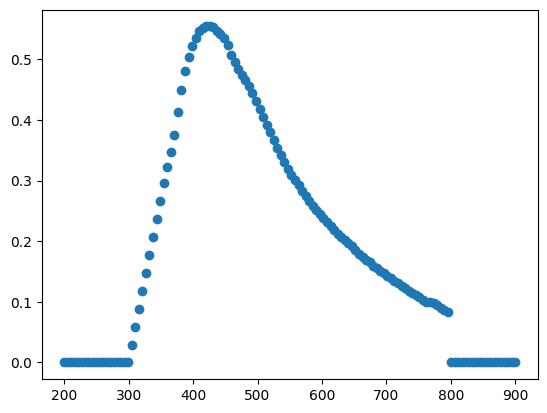

In [68]:
plt.scatter(PDE_wvs, PDEs)
plt.show()

In [149]:
PDEs.sum()

1.0

In [86]:
dist2_interpolated.shape[0]

696

In [79]:
convolution_result.sum()

9008943.822588062

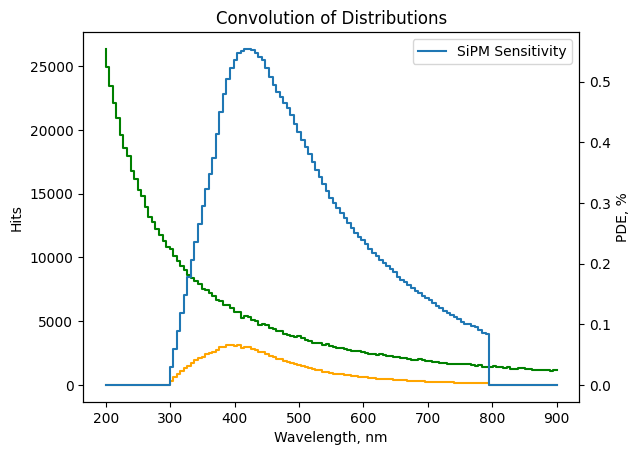

In [72]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax2.step(PDE_wvs, PDEs, label='SiPM Sensitivity')
ax1.step(PDE_wvs, a1, label='Original Distribution', c='g')
ax1.step(PDE_wvs, a1 * PDEs, label='Convolution', c='orange')

ax1.set_title('Convolution of Distributions')
ax1.set_xlabel('Wavelength, nm')
ax1.set_ylabel('Hits')
plt.ylabel('PDE, %')
# ax1.legend()
ax2.legend()
plt.show()

In [74]:
response = a1 * PDEs

In [75]:
response.sum() / a1.sum()

0.15606688261722065

In [107]:
response.sum()

75841.4915686709

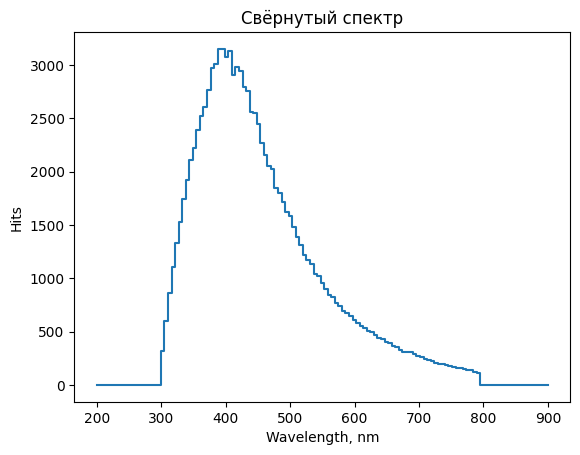

In [73]:
plt.step(PDE_wvs, a1 * PDEs, label='conv')
plt.title('Свёрнутый спектр')
plt.xlabel('Wavelength, nm')
plt.ylabel('Hits')
plt.show()

In [169]:
cut_shapes = np.zeros(1000)
for num in range(1000):
    arr = 1239.841 / np.array(file['events;2']['FarichBarrelG4Hits.energy'].array())[num] * 1e-9
    arr = arr[arr > 150]
    arr_bins = np.histogram(arr, bins=a1.shape[0])
    cut_shapes[num] = (arr_bins[0] * PDEs).sum()


KeyError: not found: b'events' with cycle 2
 in file: data\fullsim_optical_1000_pi_500_no.root

In [170]:
cut_shapes = np.zeros(1000)
for num in range(1000):
    arr = 1239.841 / np.array(file['events;1']['FarichBarrelG4Hits.energy'].array())[num] * 1e-9 # for 500
    arr = arr[arr > 150]
    arr_bins = np.histogram(arr, bins=a1.shape[0])
    cut_shapes[num] = (arr_bins[0] * PDEs).sum()


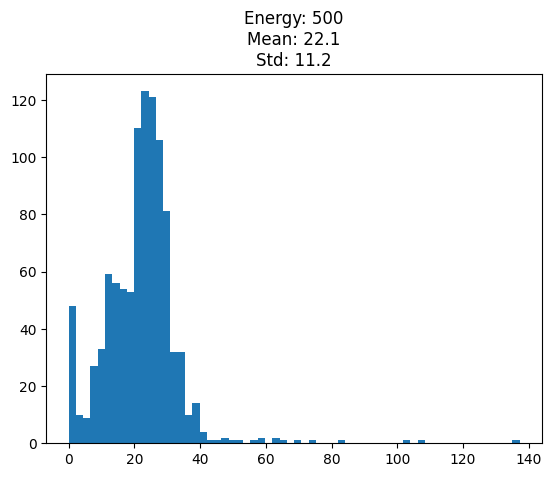

In [171]:
plt.hist(cut_shapes, bins='auto')
plt.title(f'Energy: 500\nMean: {round(cut_shapes.mean(), 1)}' + '\n' + f'Std: {round(cut_shapes.std(), 1)}')
plt.show()

In [160]:
arr_bins = np.histogram(arr, bins=a1.shape[0])

In [161]:
(arr_bins[0] * PDEs).sum() / arr_bins[0].sum()

0.15156340805916513

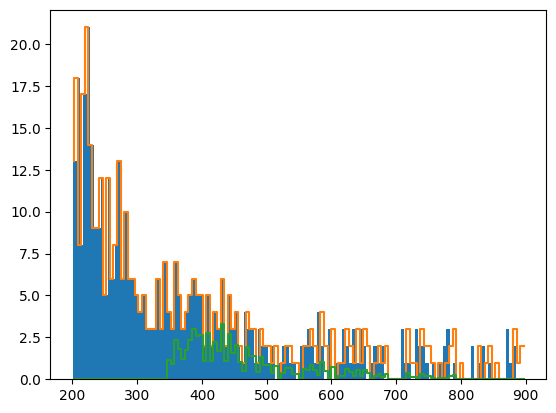

In [162]:
plt.hist(arr, bins=a1.shape[0])
plt.step(PDE_wvs, arr_bins[0])
plt.step(PDE_wvs, arr_bins[0] * PDEs)
plt.show()

In [173]:
mins = np.zeros(1000)
for num in range(1000):
    arr = 1239.841 / np.array(file['events;1']['FarichBarrelG4Hits.energy'].array())[num] * 1e-9 # for 500
    try:
        mins[num] = min(arr)
    except ValueError:
        pass

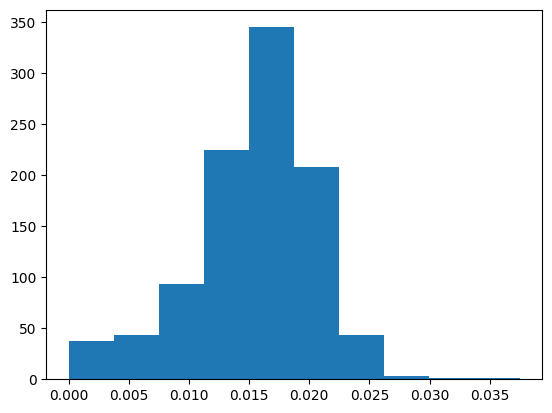

In [174]:
plt.hist(mins)
plt.show()

In [39]:
energies = np.array(file['events;1']['FarichBarrelG4Hits.energy'].array())

In [40]:
energies = np.concatenate(energies)

In [41]:
energies.shape

(460151,)

In [42]:
energies = energies[energies < 1e-7]

In [43]:
energies.shape

(458422,)

In [44]:
energies = energies * 1e9

In [45]:
energies = energies[energies < 7.5]

In [46]:
energies.shape

(458421,)

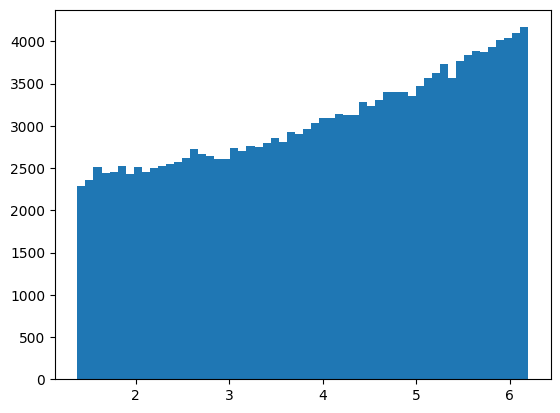

In [199]:
plt.hist(energies[energies < 7.5], bins='auto')
plt.show()

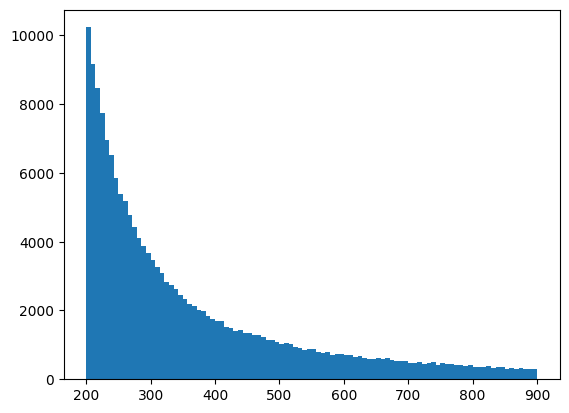

In [202]:
plt.hist(1239.8 / energies,bins='auto')
plt.show()

In [14]:
wavelengths_prototype = np.concatenate(file_prototype['raw_data;2']['event']['m_hits']['m_hits.m_photon_wl'].array())

In [12]:
wavelengths_prototype_1500 = file_prototype['raw_data;2']['event']['m_hits']['m_hits.m_photon_wl'].array()


In [15]:
wavelengths_prototype_1500.shape

(10000,)

In [244]:
wv_res = []
wv_res_len = 0
wv_res_sizes = []

In [245]:
for i in range(wavelengths_prototype_1500.shape[0]):
    if betas_prototype[i] >= 0.99569:
        wv_res.extend(wavelengths_prototype_1500[i])
        wv_res_len += 1
        wv_res_sizes.append(wavelengths_prototype_1500[i].shape[0])

In [246]:
wv_res = np.array(wv_res)
wv_res_sizes = np.array(wv_res_sizes)

In [26]:
print(wv_res.shape[0], wv_res_len, wv_res.shape[0]/wv_res_len)

46411 816 56.87622549019608


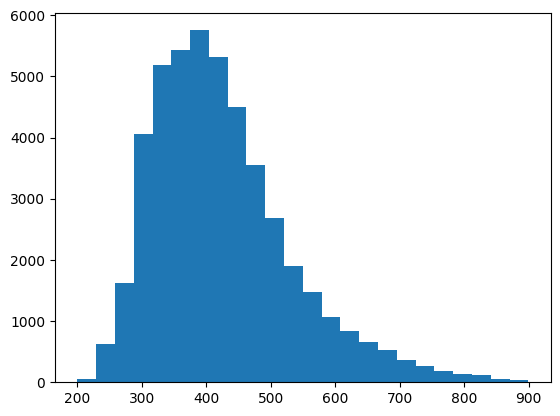

In [28]:
plt.hist(wv_res, bins='doane')
plt.show()

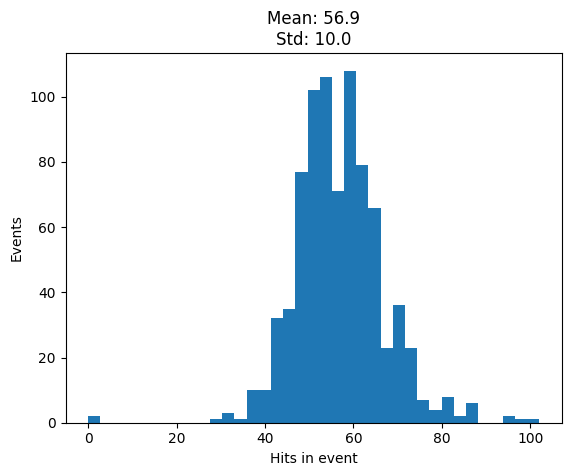

In [251]:
plt.hist(wv_res_sizes, bins='auto')
plt.xlabel('Hits in event')
plt.title(f'Mean: {round(wv_res_sizes.mean(), 1)}' + '\n' + f'Std: {round(wv_res_sizes.std(), 1)}')
plt.ylabel('Events')
plt.show()

In [187]:
mask = betas_prototype >= 0.99569

In [203]:
mask.sum()

816

In [204]:
wv_res.shape[0] / mask.sum()

56.87622549019608

In [16]:
betas_prototype = file_prototype['raw_data;2']['event']['m_beta_primary'].array()

In [190]:
wavelengths_prototype_1500 = wavelengths_prototype_1500[mask]


C:\PYTHON\Python\lib\site-packages\awkward0\array\base.py:622: FutureWarning:

In the future `np.str` will be defined as the corresponding NumPy scalar.



AttributeError: module 'numpy' has no attribute 'str'.
`np.str` was a deprecated alias for the builtin `str`. To avoid this error in existing code, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [178]:
betas_prototype[0]

0.966818333029747

In [173]:
betas_prototype.shape

(10000,)

In [55]:
wavelengths_prototype.shape

(314038,)

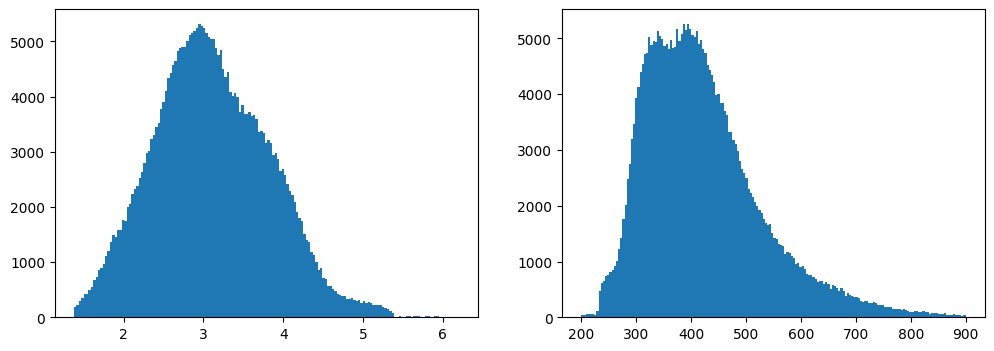

In [59]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.hist(1239.8/wavelengths_prototype, bins='auto', density=False)
plt.subplot(122)
plt.hist(wavelengths_prototype, bins='auto', density=False)
plt.show()

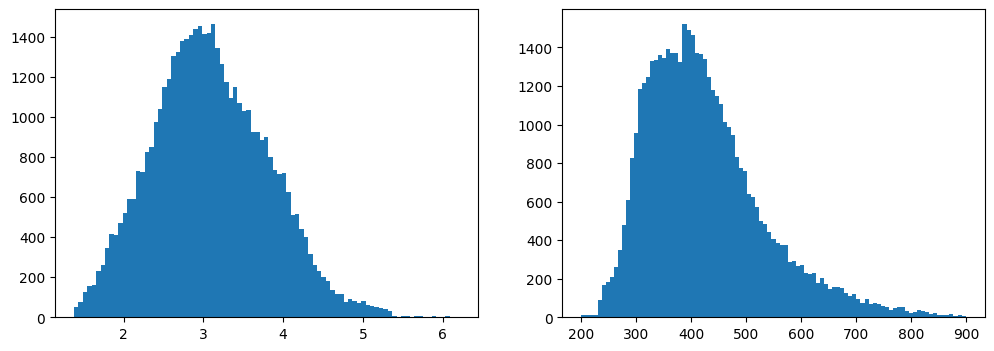

In [205]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.hist(1239.8/wv_res, bins='auto', density=False)
plt.subplot(122)
plt.hist(wv_res, bins='auto', density=False)
plt.show()

In [85]:
xml_energies, xml_r = [], []
xml_data = []
with open(os.path.join(datadir, 'rindex.txt')) as f:
    for line in f:
        xml_data.append(np.array(line.split('*eV '), dtype='float64'))
        # print(np.array(line.split('*eV '), dtype='float64'))
        # break
xml_data = np.array(xml_data)

In [86]:
xml_data.shape

(71, 2)

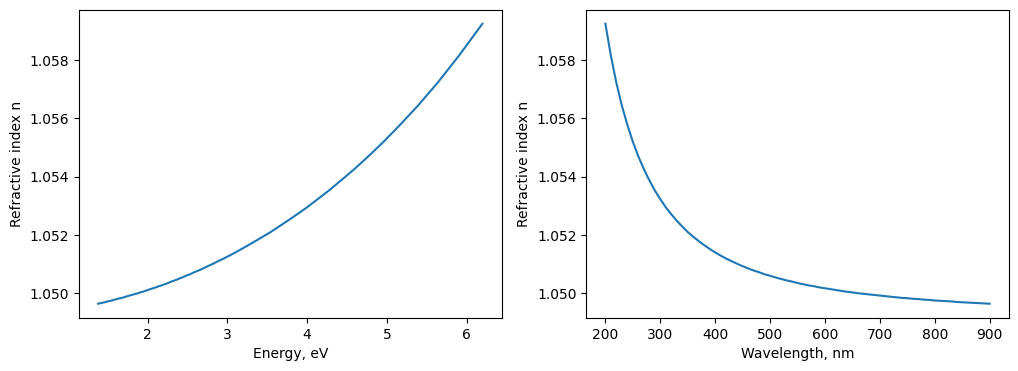

In [10]:
# plt.subplots(1, 2)
plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.plot(xml_data[:,0], xml_data[:,1])
plt.xlabel('Energy, eV')
plt.ylabel('Refractive index n')
plt.subplot(122)
plt.plot(1239.8 / xml_data[:,0], xml_data[:,1])
plt.xlabel('Wavelength, nm')
plt.ylabel('Refractive index n')
plt.show()

In [92]:
binned_wavelengths_prototype = np.histogram(wavelengths_prototype, 1239.8 / xml_data[:,0])
binned_wavelengths_full = np.histogram(lambdas, 1239.8 / xml_data[:,0])

binned_energies_prototype = np.histogram(1239.841 / wavelengths_prototype, xml_data[:,0][::-1])

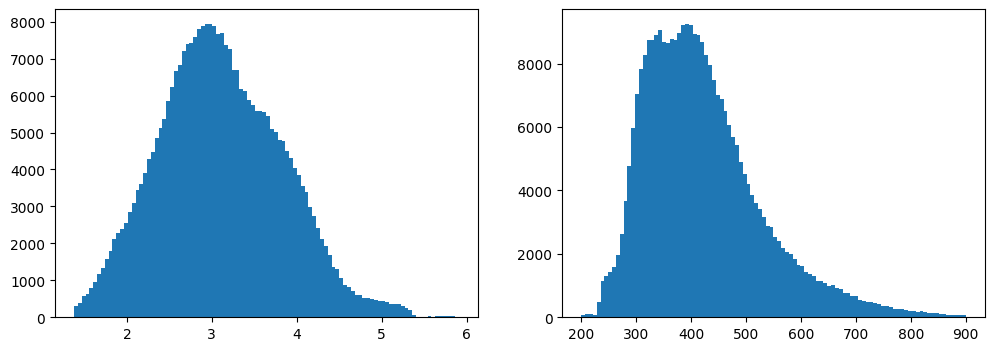

In [110]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.hist(1239.8/wavelengths_prototype, bins= new_bins, density=False)
plt.subplot(122)
plt.hist(wavelengths_prototype, bins= new_wv_bins, density=False)
plt.show()

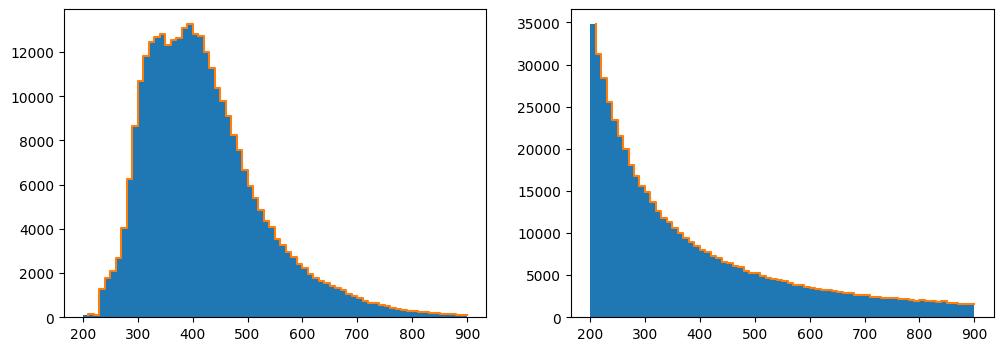

In [66]:
plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.hist(wavelengths_prototype, bins=1239.8 / xml_data[:,0], density=False)
plt.step(binned_wavelengths_prototype[1][1:], binned_wavelengths_prototype[0])

plt.subplot(122)
plt.hist(lambdas, bins=1239.8 / xml_data[:,0], density=False)
plt.step(binned_wavelengths_full[1][1:], binned_wavelengths_full[0])
plt.show()

In [67]:
xml_data[:,1]

array([1.05925, 1.05815, 1.05722, 1.05644, 1.05578, 1.0552 , 1.0547 ,
       1.05426, 1.05388, 1.05353, 1.05323, 1.05295, 1.05271, 1.05249,
       1.05229, 1.0521 , 1.05194, 1.05179, 1.05165, 1.05152, 1.0514 ,
       1.05129, 1.05119, 1.0511 , 1.05101, 1.05093, 1.05085, 1.05078,
       1.05072, 1.05065, 1.0506 , 1.05054, 1.05049, 1.05044, 1.0504 ,
       1.05035, 1.05031, 1.05027, 1.05024, 1.0502 , 1.05017, 1.05014,
       1.05011, 1.05008, 1.05005, 1.05003, 1.05   , 1.04998, 1.04996,
       1.04994, 1.04992, 1.0499 , 1.04988, 1.04986, 1.04984, 1.04983,
       1.04981, 1.0498 , 1.04978, 1.04977, 1.04975, 1.04974, 1.04973,
       1.04972, 1.0497 , 1.04969, 1.04968, 1.04967, 1.04966, 1.04965,
       1.04964])

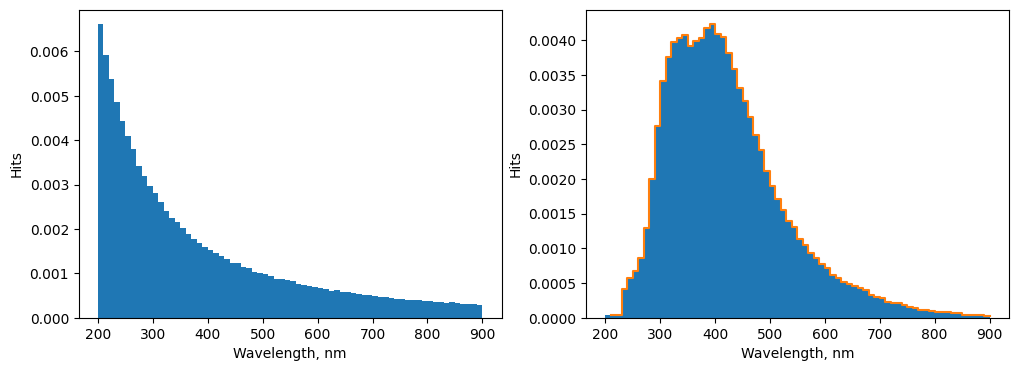

In [80]:
plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.hist(lambdas, bins=1239.8 / xml_data[:,0], density=True, alpha=1)

# plt.hist(wavelengths_prototype, bins=1239.8 / xml_data[:,0], density=True, alpha=0.5)
plt.xlabel('Wavelength, nm')
plt.ylabel('Hits')

plt.subplot(122)
plt.hist(wavelengths_prototype, bins=1239.8 / xml_data[:,0], density=True)
plt.step(binned_wavelengths_prototype[1][1:], binned_wavelengths_prototype[0] / binned_wavelengths_prototype[0].sum() / 10)
plt.xlabel('Wavelength, nm')
plt.ylabel('Hits')

plt.show()

In [81]:
(binned_wavelengths_prototype[0] / binned_wavelengths_prototype[0].sum() / 10).sum()

0.1

In [86]:
(binned_wavelengths_full[0] / binned_wavelengths_full[0].sum()).sum()

0.9999999999999999

In [89]:
reg = LinearRegression().fit((binned_wavelengths_full[0] / binned_wavelengths_full[0].sum()).reshape(-1, 1), xml_data[:,1][1:])

In [92]:
print(reg.coef_, reg.intercept_)

[0.13432779] 1.0492391744162548


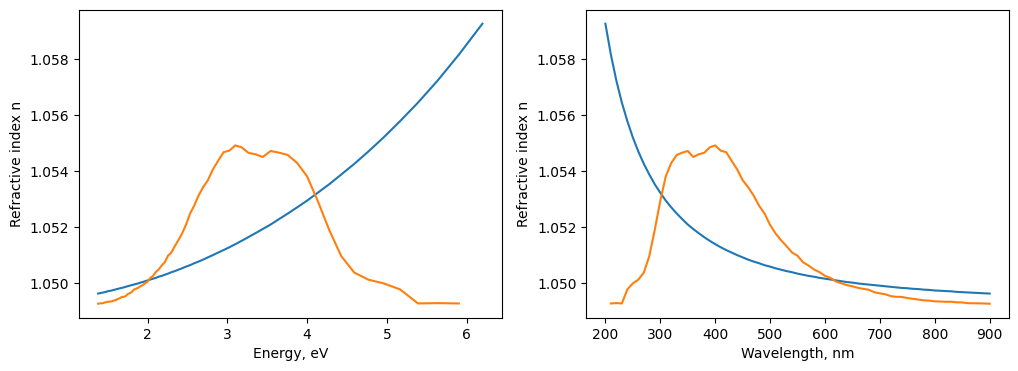

In [112]:

plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.plot(xml_data[:,0], xml_data[:,1])
plt.plot(xml_data[:,0][1:], (binned_wavelengths_prototype[0] / binned_wavelengths_prototype[0].sum())*reg.coef_+ reg.intercept_ )
plt.xlabel('Energy, eV')
plt.ylabel('Refractive index n')
plt.subplot(122)
plt.plot(1239.8 / xml_data[:,0], xml_data[:,1])
plt.plot(binned_wavelengths_prototype[1][1:], (binned_wavelengths_prototype[0] / binned_wavelengths_prototype[0].sum())*reg.coef_+ reg.intercept_ )
plt.xlabel('Wavelength, nm')
plt.ylabel('Refractive index n')
plt.show()

In [101]:
out = (binned_wavelengths_prototype[0] / binned_wavelengths_prototype[0].sum())*reg.coef_+ reg.intercept_

In [106]:
out

array([1.04928794, 1.04929991, 1.04928879, 1.04978883, 1.05000398,
       1.05013401, 1.05038681, 1.05097368, 1.05191685, 1.05294258,
       1.05381389, 1.05429297, 1.05457528, 1.05465826, 1.05471772,
       1.05450556, 1.05460094, 1.0546527 , 1.05484604, 1.05491704,
       1.05473012, 1.05467708, 1.05436825, 1.05406199, 1.05367787,
       1.05343021, 1.05312993, 1.05276977, 1.05248404, 1.05208666,
       1.05177954, 1.05153958, 1.05132528, 1.05110285, 1.05098651,
       1.05075638, 1.05063832, 1.05049888, 1.05040264, 1.05027132,
       1.05019732, 1.05006985, 1.05000697, 1.04993982, 1.04989833,
       1.04984443, 1.04980765, 1.04977557, 1.04968574, 1.04964853,
       1.04961388, 1.04954758, 1.04952491, 1.04952063, 1.04947999,
       1.04945347, 1.04942695, 1.04939787, 1.04938931, 1.04936279,
       1.04935638, 1.04934782, 1.04934868, 1.049329  , 1.0493243 ,
       1.04929863, 1.04929393, 1.04929393, 1.04928623, 1.04927853])

In [125]:
with open(os.path.join(datadir, 'rindex_out.txt'), 'w') as f:
    f.write('6.19921*eV 1.04929\n')
    for en, n in zip(xml_data[:,0][1:], out):
        f.write('    {:.5f}*eV {:.5f}\n'.format(round(en, 5), round(n, 5)))


In [8]:
new_bins = np.linspace(1.37760, 5.90401, 101)
new_wv_bins = np.linspace(200, 900, 101)

In [76]:
wavelengths_prototype.shape[0] / betas_prototype.shape[0]

31.4038

In [206]:
wv_res.shape[0] / mask.sum()

56.87622549019608

In [20]:
test_num = 35
filepath_new = os.path.join(datadir, f'fullsim_optical_1000_pi_1500_spectre_test_{test_num}.root')
file_new = uproot.open(filepath_new)
energies_new = np.array(file_new['events;1']['FarichBarrelG4Hits.energy'].array()) * 1e9
energies_new = np.concatenate(energies_new)
energies_new = energies_new[energies_new < 7.5]
lambdas_new = 1239.841 / energies_new
# lambdas_new = np.concatenate(lambdas_new)
# lambdas_new = lambdas_new[lambdas_new > 150]
print(lambdas_new.shape)
print(lambdas_new.shape[0] / np.array(file_new['events;1']['allGenParticles.core.pdgId'].array()).shape[0])

(324251,)
324.251


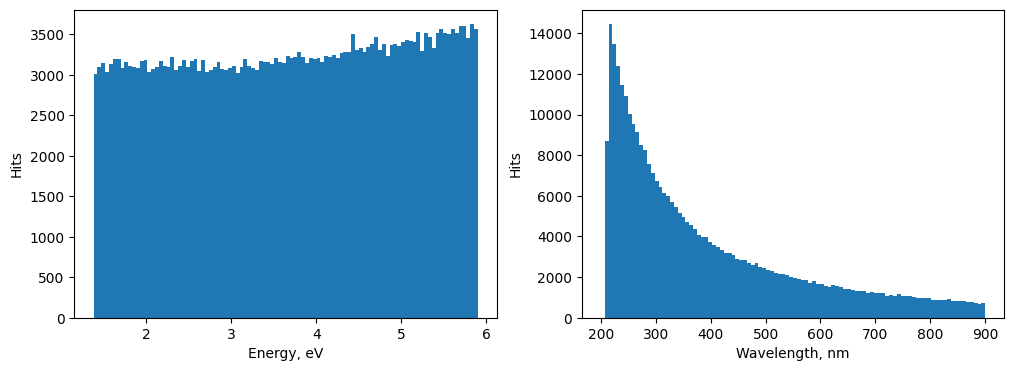

In [21]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.hist(energies_new, bins=new_bins)
plt.xlabel('Energy, eV')
plt.ylabel('Hits')
plt.subplot(122)
plt.hist(lambdas_new, bins=new_wv_bins)
plt.xlabel('Wavelength, nm')
plt.ylabel('Hits')
plt.show()

In [ ]:
plot_cyl(file)